In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1.1 Load
df = pd.read_csv('balanced_agv_dataset.csv', parse_dates=['created_at'])

# 1.2 Handle missing / invalid
df = df.dropna()   # or more nuanced imputation

# 1.3 Encode categoricals
le_action = LabelEncoder()
df['Action_enc'] = le_action.fit_transform(df['navigation_action'])

le_zone   = LabelEncoder()
df['Zone_enc']   = le_zone.fit_transform(df['high_traffic_zone'])

le_obs    = LabelEncoder()
df['Obs_enc']    = le_obs.fit_transform(df['obstacle_present'])

le_risk   = LabelEncoder()
df['Risk_enc']   = le_risk.fit_transform(df['collision_risk_class'])

# 1.4 Scale numeric features
scaler = StandardScaler()
num_cols = ['ultrasonic_cm','speed (cm/sec)','robot position x','robot position y']
df[num_cols] = scaler.fit_transform(df[num_cols])


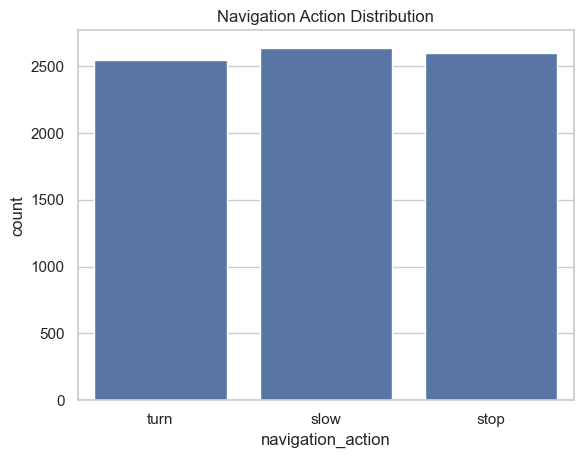

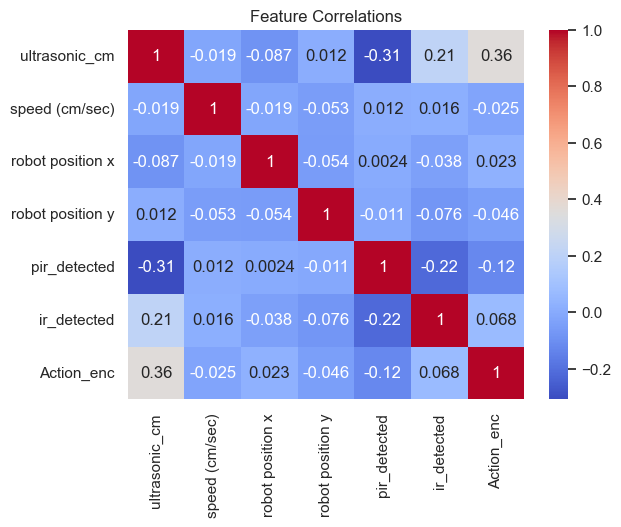

KeyError: "None of ['created_at'] are in the columns"

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# 2.1 Class Balance
sns.countplot(x='navigation_action', data=df)
plt.title("Navigation Action Distribution"); plt.show()

# 2.2 Correlation Heatmap
corr = df[num_cols + ['pir_detected','ir_detected','Action_enc']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlations"); plt.show()

# 2.3 Time Series Plot (Distance)
df.set_index('created_at')['ultrasonic_cm'].plot(figsize=(12,3))
plt.title("Ultrasonic Distance Over Time"); plt.show()



# Set general style
sns.set(style="whitegrid")

# Categorical features to include (excluding navigation_action)
categorical_cols = ['pir status', 'ir status']

# Numerical columns
numerical_cols = ['ultrasonic_cm', 'distance to obstacle (cms)', 'robot position x', 
                  'robot position y', 'speed (cm/sec)', 'path_efficiency_score']

# --- CATEGORICAL FREQUENCY COUNTS ---
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Frequency Count of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- NUMERICAL DISTRIBUTIONS ---
for col in numerical_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram
    sns.histplot(df[col], kde=False, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Histogram of {col}")
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Boxplot of {col}")
    
    # KDE using Gaussian KDE for stability
    clean_data = pd.to_numeric(df[col], errors='coerce').dropna().astype('float64').values
    if len(clean_data) > 1:
        kde = gaussian_kde(clean_data)
        x_vals = np.linspace(min(clean_data), max(clean_data), 500)
        y_vals = kde(x_vals)
        axes[2].plot(x_vals, y_vals, color='salmon')
        axes[2].fill_between(x_vals, y_vals, color='salmon', alpha=0.4)
    axes[2].set_title(f"KDE Plot of {col}")
    
    plt.tight_layout()
    plt.show()
    

# Define the three variable pairs for numerical vs numerical analysis
plot_pairs = [
    ("speed (cm/sec)", "ultrasonic_cm")
]

# Generate scatter plots for each pair with correlation
for x_var, y_var in plot_pairs:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df, x=x_var, y=y_var, alpha=0.5)
    plt.title(f"{x_var} vs {y_var}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<AxesSubplot:xlabel='collision_risk_class', ylabel='speed (cm/sec)'>

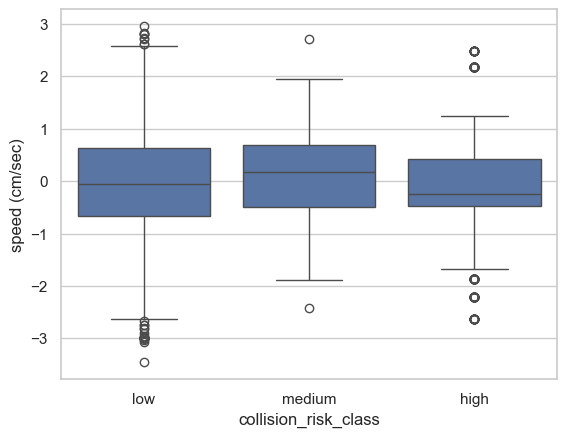

In [44]:
sns.boxplot(x='collision_risk_class', y='speed (cm/sec)', data=df)

<AxesSubplot:xlabel='high_traffic_zone', ylabel='path_efficiency_score'>

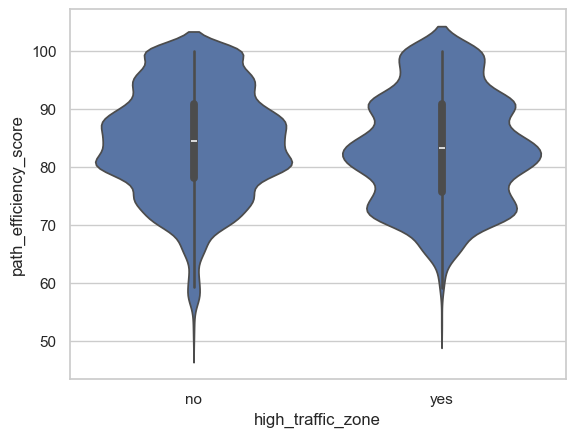

In [45]:
sns.violinplot(x='high_traffic_zone', y='path_efficiency_score', data=df)

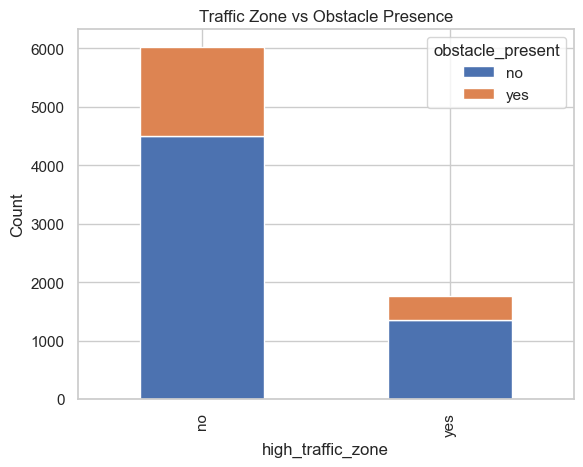

In [50]:
# Stacked bar plot
pd.crosstab(df['high_traffic_zone'], df['obstacle_present']).plot(kind='bar', stacked=True)
plt.title("Traffic Zone vs Obstacle Presence")
plt.ylabel("Count")
plt.show()

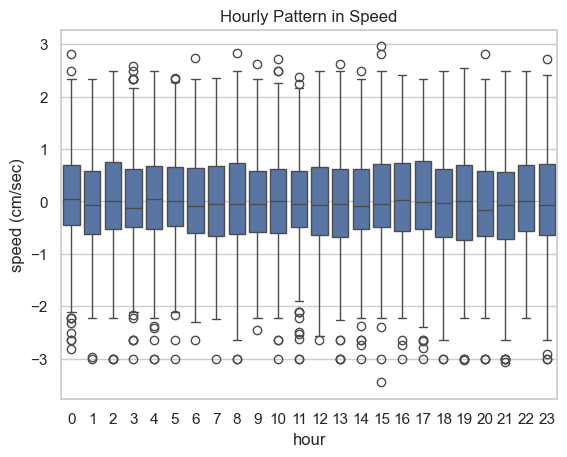

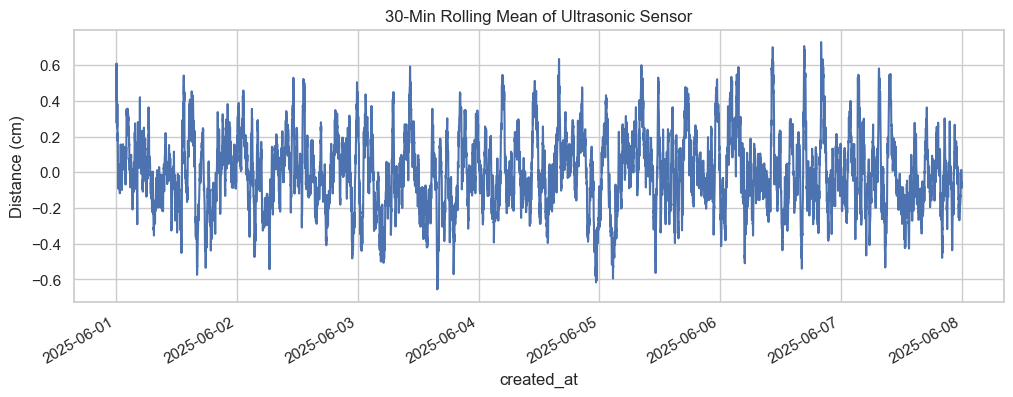

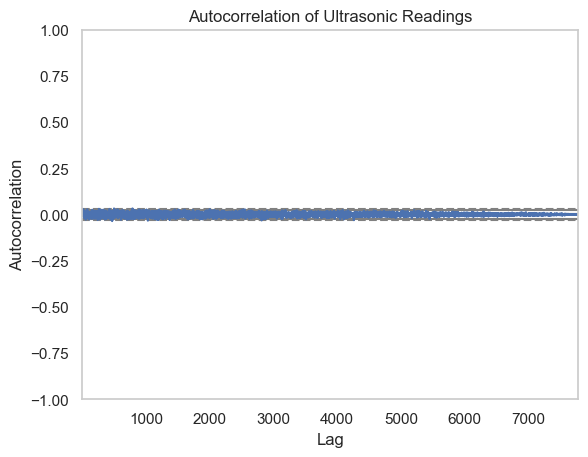

In [54]:
import seaborn as sns
df['hour'] = df['created_at'].dt.hour
sns.boxplot(x='hour', y='speed (cm/sec)', data=df)
plt.title('Hourly Pattern in Speed')
plt.show()





df_rolling = df.set_index('created_at')['ultrasonic_cm'].rolling('30min').mean()
df_rolling.plot(figsize=(12, 4), title='30-Min Rolling Mean of Ultrasonic Sensor')
plt.ylabel('Distance (cm)')
plt.show()



from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.set_index('created_at')['ultrasonic_cm'])
plt.title('Autocorrelation of Ultrasonic Readings')
plt.show()


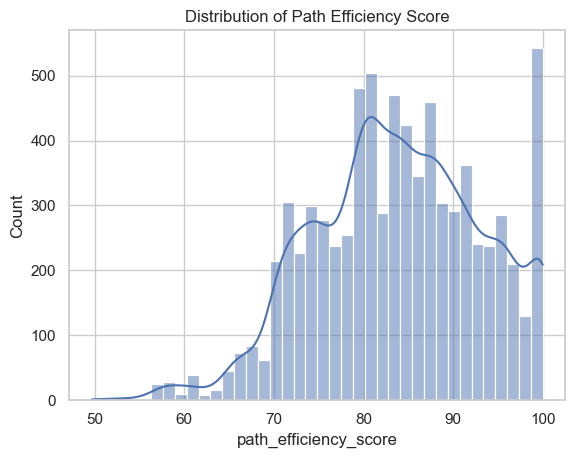

In [57]:
sns.histplot(df['path_efficiency_score'], kde=True)
plt.title('Distribution of Path Efficiency Score')
plt.show()


In [31]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 3.1.1 Feature/Target split
features = ['ultrasonic_cm','pir_detected','ir_detected','Zone_enc',
            'speed (cm/sec)','Obs_enc','Risk_enc']
X = df[features]
y = df['Action_enc']

# 3.1.2 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3.1.3 Train XGBoost classifier
clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)

# 3.1.4 Predict
y_pred = clf.predict(X_test)


C:\Users\sivar\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 98.97%

Classification Report:
               precision    recall  f1-score   support

        slow       0.99      1.00      0.99       528
        stop       0.98      1.00      0.99       521
        turn       1.00      0.97      0.98       509

    accuracy                           0.99      1558
   macro avg       0.99      0.99      0.99      1558
weighted avg       0.99      0.99      0.99      1558



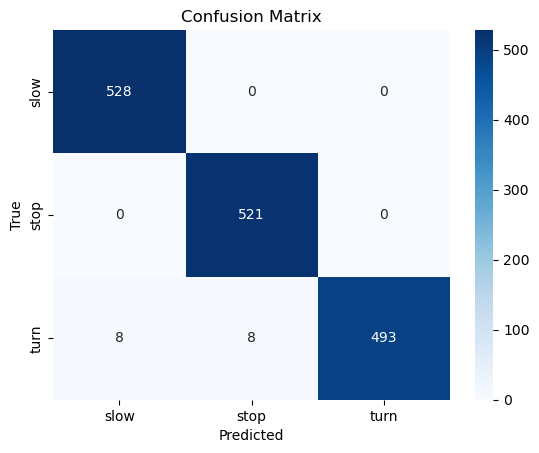

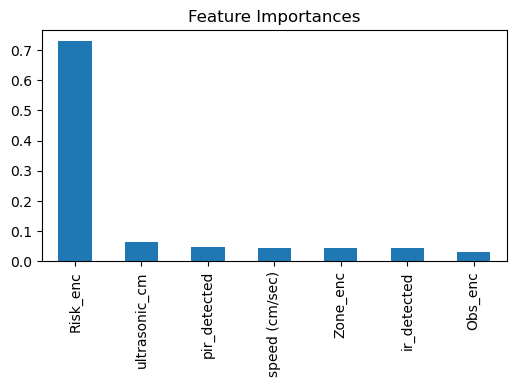

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 4.0 Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# 4.1 Classification report
report = classification_report(y_test, y_pred, target_names=le_action.classes_)
print("Classification Report:\n", report)

# 4.2 Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_action.classes_, yticklabels=le_action.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# 4.3 Feature importance
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,3))
importances.plot.bar()
plt.title("Feature Importances")
plt.show()
